In [97]:
from torch import cuda
import torch
from torch.utils.data import Dataset
from transformers import DistilBertModel
from sklearn import metrics
cuda.is_available()

True

In [14]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
# For reproducibility
torch.manual_seed(0)


In [15]:
import numpy as np
import pandas as pd
import re
import operator
import string
from collections import defaultdict

import tokenize
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import pickle
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification



# Load the tweet data

In [16]:
df_train = pd.read_csv(r'dataset\trainningdata.csv',encoding="ISO-8859-1",names= ["target", "ids", "date", "flag", "user", "text"])
df_test = pd.read_csv(r'dataset\testdata.csv',encoding="ISO-8859-1",names= ["target", "ids", "date", "flag", "user", "text"])

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (1600000, 6)
Training Set Memory Usage = 73.24 MB
Test Set Shape = (498, 6)
Test Set Memory Usage = 0.02 MB


# Pre process and data analysis 

###  Looking for missing values or duplicated values

In [17]:
df_train.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [18]:
df_train.duplicated().sum()

0

In [19]:
df_test.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [20]:
df_test.duplicated().sum()

0

### Target distribution 

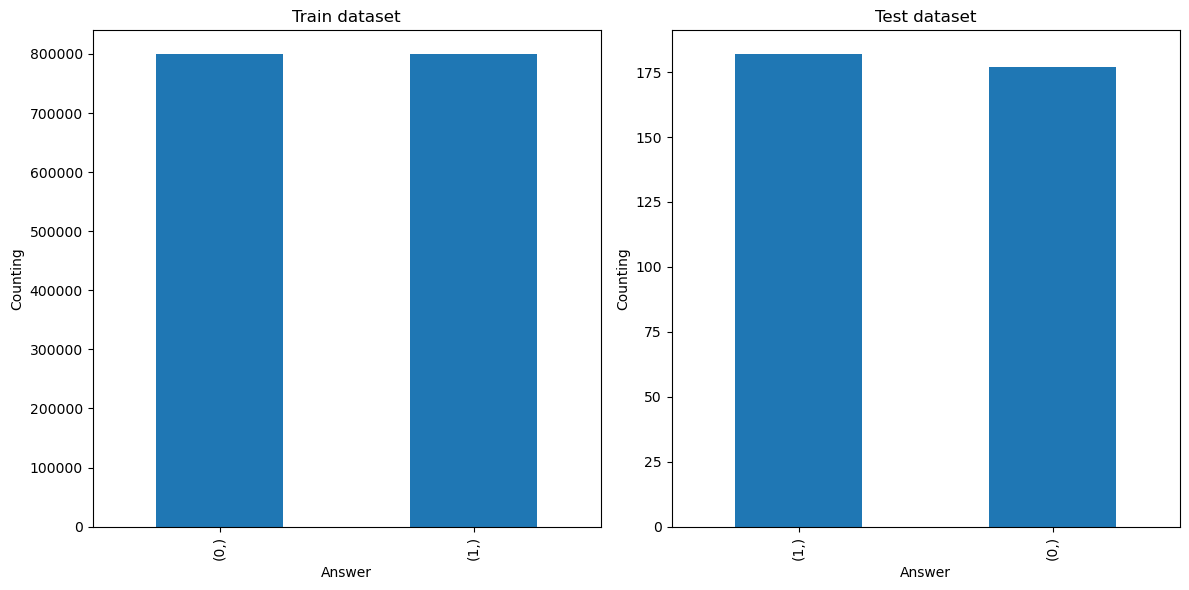

In [115]:
target=['target']

train_target = df_train[target].value_counts()

test_target = df_test[target].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))


train_target.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Answer')
axes[0].set_ylabel('Counting')
axes[0].set_title('Train dataset')

test_target.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Answer')
axes[1].set_ylabel('Counting')
axes[1].set_title('Test dataset')

plt.tight_layout()

plt.show()


### Eliminating neutral targets from the test dataset and reclassifying them


Since the training dataset doesn't include neutral tweets, a decision was made to exclude the neutral tweets from the test set. Following this, the reclassification of the target variable is performed as follows:

* 0 as negative tweets
* 1 as positive tweets 

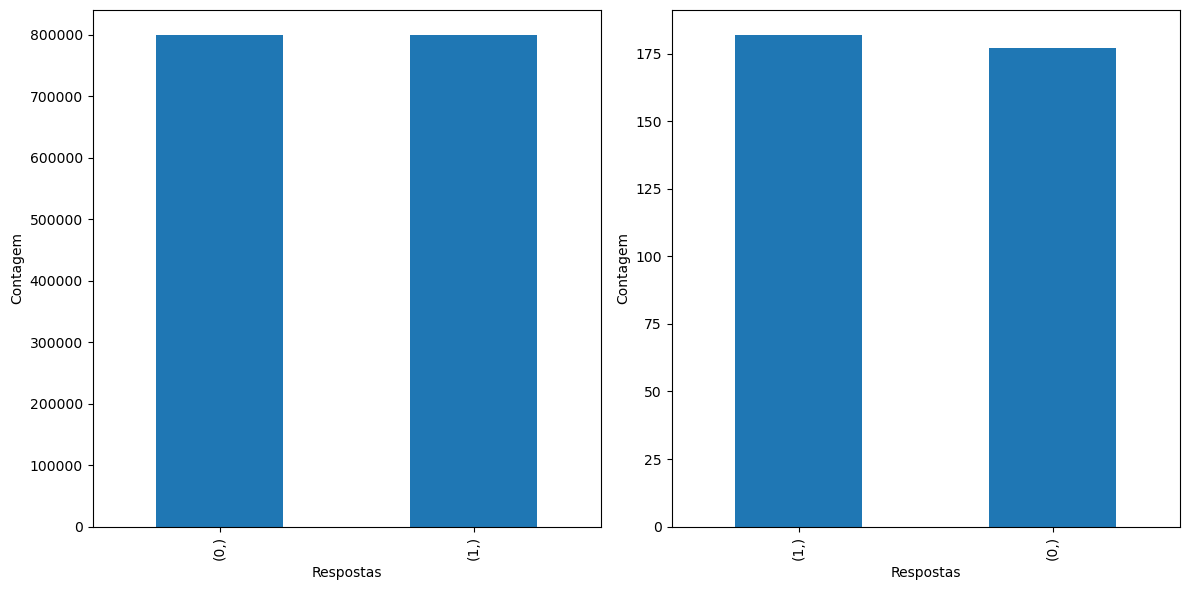

In [22]:
# Removing neutral tweets
df_test = df_test.loc[df_test['target']!= 2 ]
target=['target']

# relabeling target
df_train['target'] =df_train['target'].apply(lambda x : 1 if x==4 else x)
df_test['target'] =df_test['target'].apply(lambda x : 1 if x==4 else x)
# graphics
train_target = df_train[target].value_counts()

test_target = df_test[target].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))


train_target.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Answer')
axes[0].set_ylabel('Counting')

test_target.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Answer')
axes[1].set_ylabel('Counting')

# Ajuste o layout dos subplots
plt.tight_layout()

# Exiba os gráficos
plt.show()

### Concatenating the data 
With the removing of neutral tweets from test dataset the proportions of target became different comparing with the train dataset, to repair that all the data will be put together and after the pre-processing the data will be splited.

In [23]:
df =pd.concat([df_train,df_test], ignore_index= True,sort=True)

# Use .sample to shuffle the data that has been concatenated
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Meta features

Some meta features are created to take a better understanding of the dataset some the meta features created are:

* word_count number of words in text
* unique_word_count number of unique words in text
* stop_word_count number of stop words in text
* url_count number of urls in text
* mean_word_length average character count in words
* char_count number of characters in text
* punctuation_count number of punctuations in text
* hashtag_count number of hashtags (#) in text
* mention_count number of mentions (@) in text

In [24]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))


# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))


# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


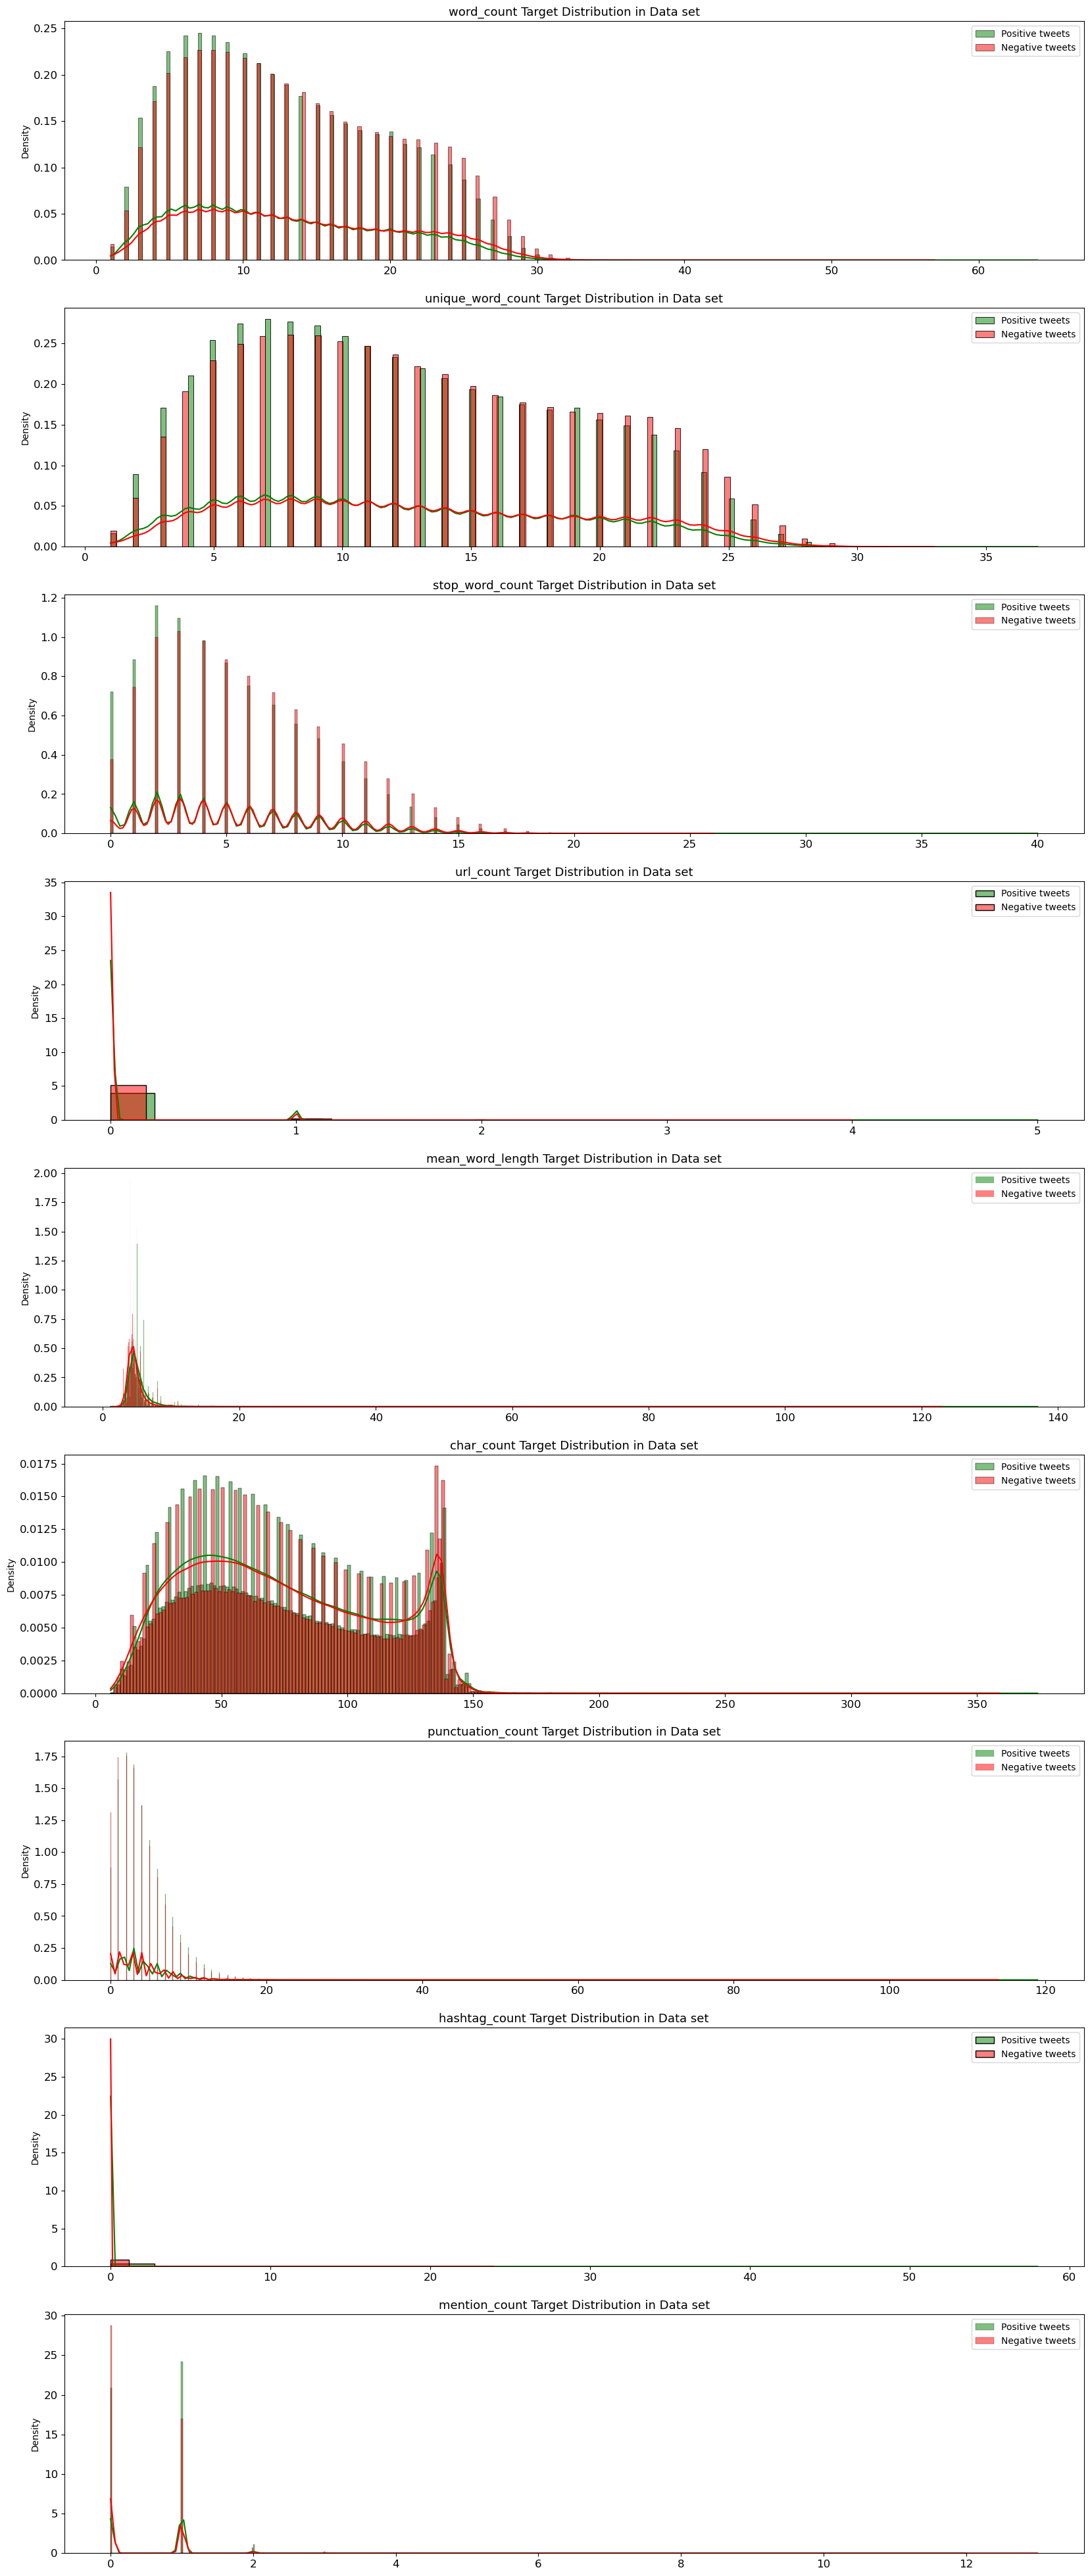

In [25]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
NEGATIVE_TWEETS = df['target']==0

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df.loc[~NEGATIVE_TWEETS][feature],kde = True, stat="density", label='Positive tweets', ax=axes[i], color='green')
    sns.histplot(df.loc[NEGATIVE_TWEETS][feature], kde = True, stat="density", label='Negative tweets', ax=axes[i], color='red')

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'{feature} Target Distribution in Data set', fontsize=13)
   
plt.show()

The graphs of metafeatures show's that positive and negative tweets have a similar distribution so probably it would not be interesting to put these features in to the model.

### N-grams

#### Unigrams

In [26]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split() if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]


# Unigrams
positive_twitter_unigrams = defaultdict(int)
negative_twitter_unigrams = defaultdict(int)

for tweet in df[NEGATIVE_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        negative_twitter_unigrams[word] += 1
        
for tweet in df[~NEGATIVE_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        positive_twitter_unigrams[word] += 1

# negative unigrams df
df_negative_tweet_unigrams = pd.DataFrame(list(negative_twitter_unigrams.items()), columns=['unigram', 'count'])
df_negative_tweet_unigrams = df_negative_tweet_unigrams.sort_values(by='count', ascending=False)

# positive unigrams df 
df_positive_tweet_unigrams = pd.DataFrame(list(positive_twitter_unigrams.items()), columns=['unigram', 'count'])
df_positive_tweet_unigrams = df_positive_tweet_unigrams.sort_values(by='count', ascending=False)

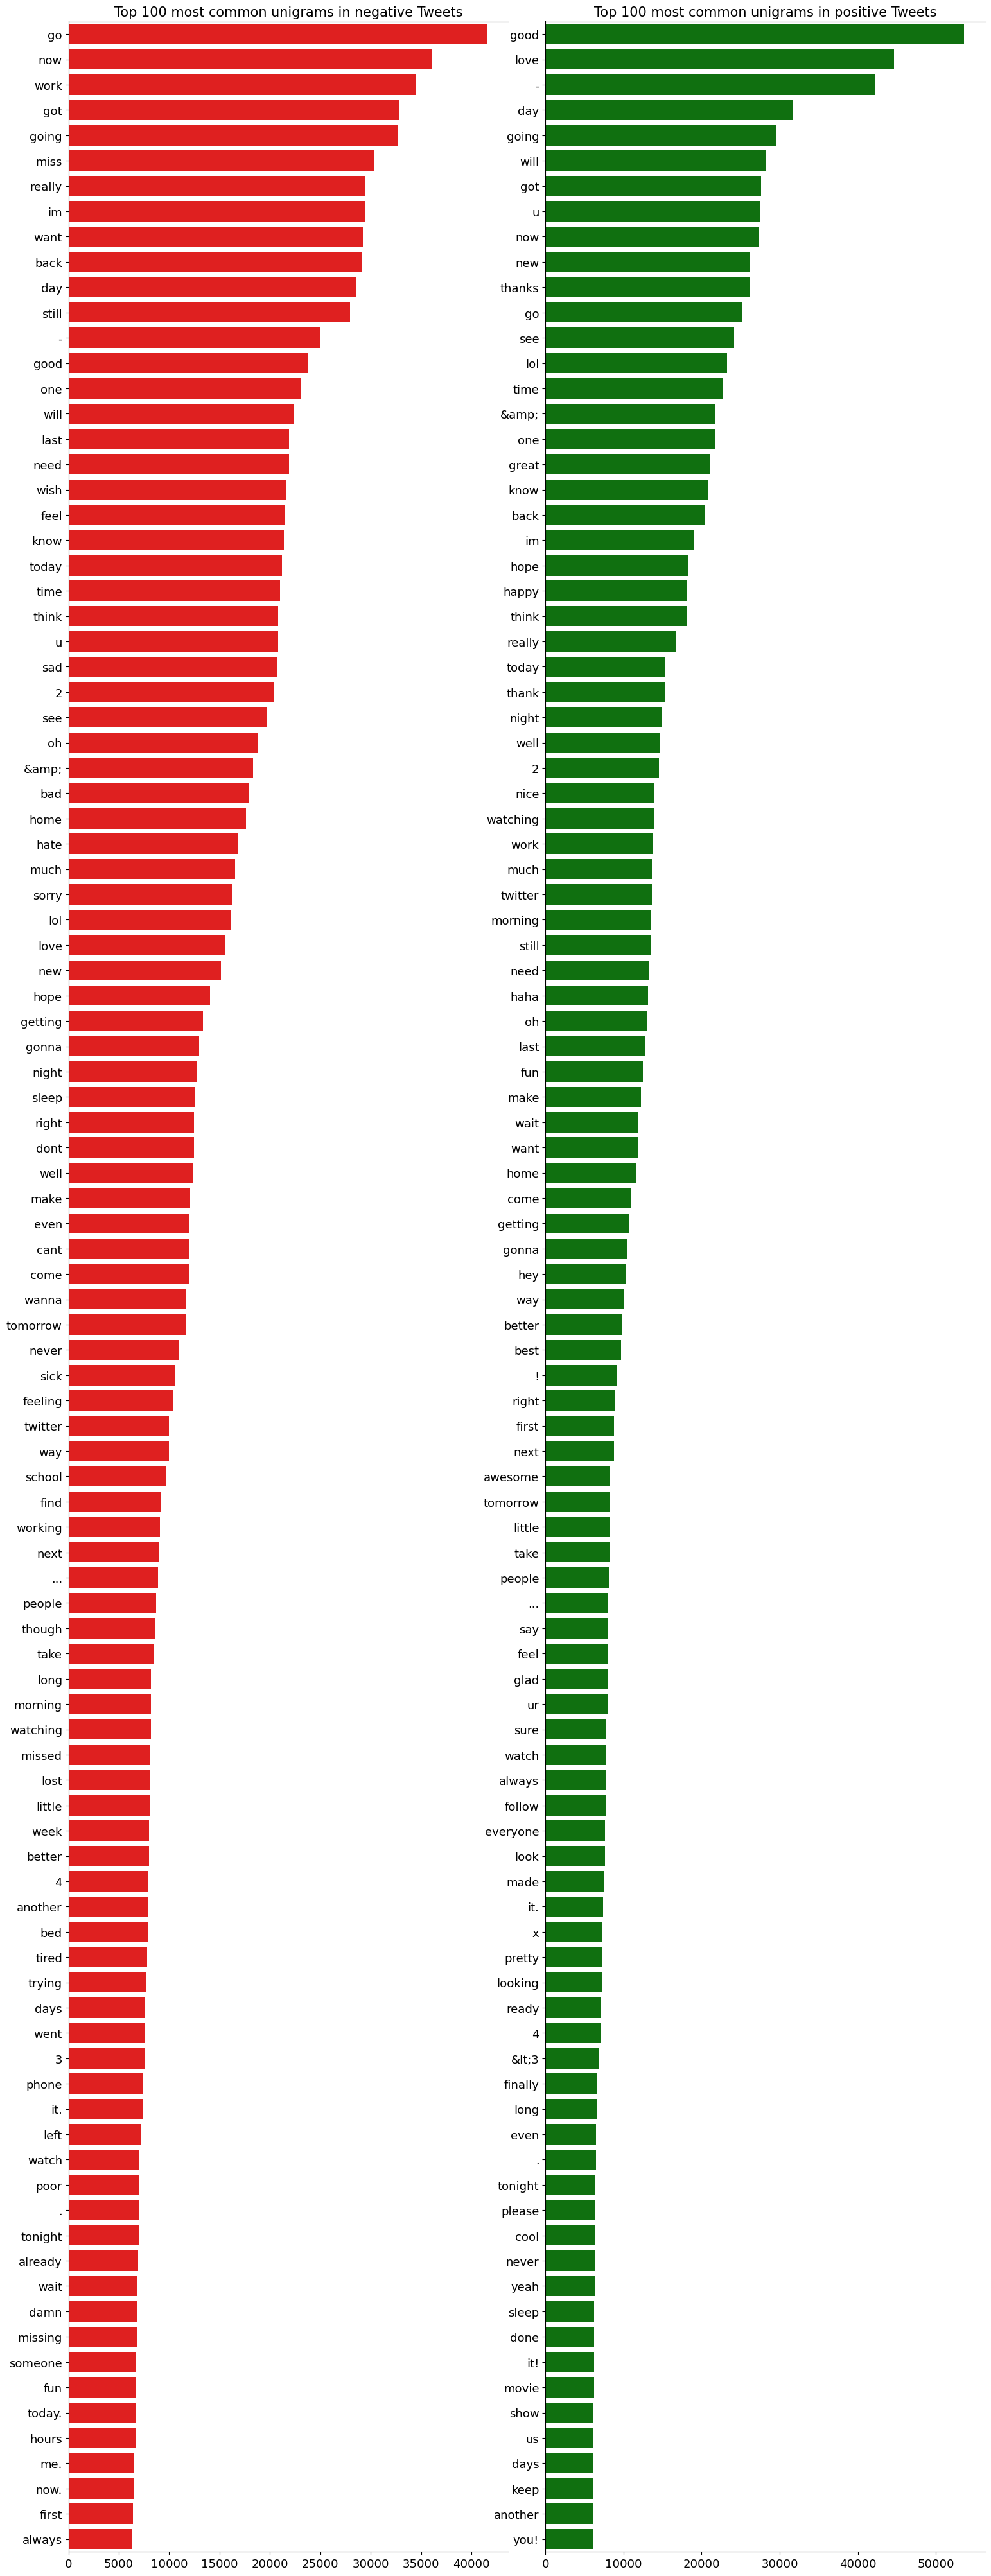

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 40), dpi=100)
plt.tight_layout()

sns.barplot(y=df_negative_tweet_unigrams['unigram'].values[:100], x=df_negative_tweet_unigrams['count'].values[:100], ax=axes[0], color='red')
sns.barplot(y=df_positive_tweet_unigrams['unigram'].values[:100], x=df_positive_tweet_unigrams['count'].values[:100], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top 100 most common unigrams in negative Tweets', fontsize=15)
axes[1].set_title(f'Top 100 most common unigrams in positive Tweets', fontsize=15)

plt.show()

Some of the most common unigrams in negative tweets are words that is usually used in negative tweets like "miss", "sad", "bad". The word "work" appeared as the most common noun unigram in the dataset

Some of the most common unigrams in positive tweets are words that is usually used in negative tweets like "good","love","happy"

#### Bi-grams

In [28]:
# Bigrams
positive_twitter_bigrams = defaultdict(int)
negative_twitter_bigrams = defaultdict(int)

for tweet in df[NEGATIVE_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram = 2):
        negative_twitter_bigrams[word] += 1
        
for tweet in df[~NEGATIVE_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram = 2):
        positive_twitter_bigrams[word] += 1

# negative unigrams df
df_negative_tweet_bigrams = pd.DataFrame(list(negative_twitter_bigrams.items()), columns=['bigram', 'count'])
df_negative_tweet_bigrams = df_negative_tweet_bigrams.sort_values(by='count', ascending=False)

# positive unigrams df 
df_positive_tweet_bigrams = pd.DataFrame(list(positive_twitter_bigrams.items()), columns=['bigram', 'count'])
df_positive_tweet_bigrams = df_positive_tweet_bigrams.sort_values(by='count', ascending=False)


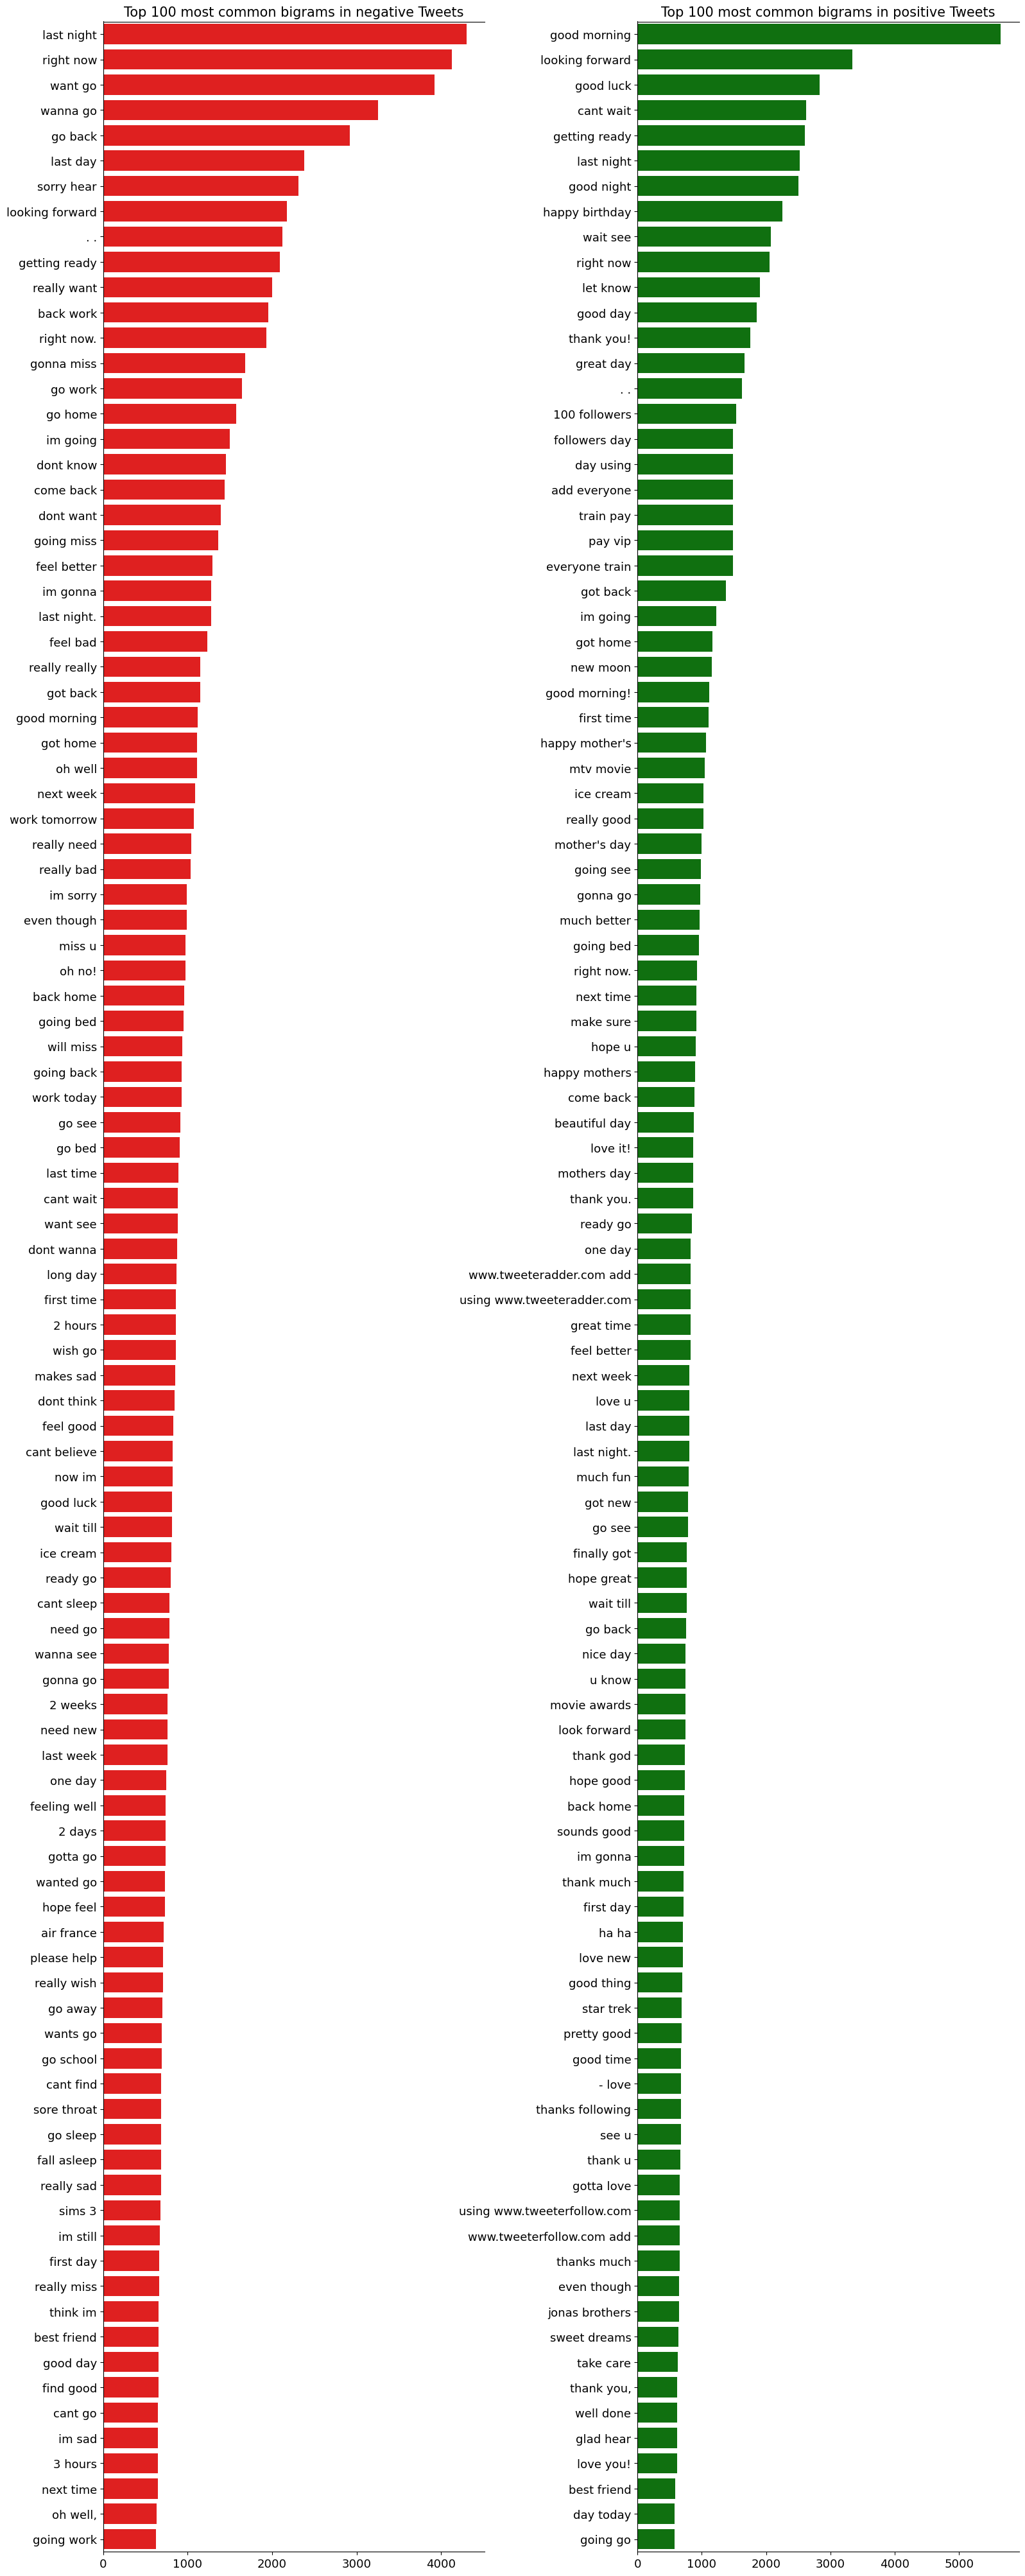

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 40), dpi=100)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
sns.barplot(y=df_negative_tweet_bigrams['bigram'].values[:100], x=df_negative_tweet_bigrams['count'].values[:100], ax=axes[0], color='red')
sns.barplot(y=df_positive_tweet_bigrams['bigram'].values[:100], x=df_positive_tweet_bigrams['count'].values[:100], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top 100 most common bigrams in negative Tweets', fontsize=15)
axes[1].set_title(f'Top 100 most common bigrams in positive Tweets', fontsize=15)

plt.show()

### Embedding and text cleaning

In [30]:
glove_embeddings = np.load(r'dataset/glove.840B.300d.pkl', allow_pickle=True)

In [31]:
def build_vocab(X):
    tweets = X.apply(lambda s: s.split()).values
    vocab = {}
    
    # Loop for vocab searching 
    for tweet in tweets:
        for word in tweet:
            try: 
                vocab[word]+=1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)
    
    covered ={}
    oov = {}
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
    
    vocab_coverage = len(covered)/len(vocab)
    text_coverage = (n_covered/(n_covered+n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_oov, vocab_coverage, text_coverage

df_oov, df_vocab_coverage, df_text_coverage = check_embeddings_coverage(df['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in data set'.format(df_vocab_coverage, df_text_coverage))

GloVe Embeddings cover 15.41% of vocabulary and 84.32% of text in data set


### Cleanning 

Tweets requires a lot of cleaning, but it's not possible to do that manually because of the larger number of data, therefore a general aproach have to be considered:

* The most commum adjust is separating the word from  punctuation
* Contractions are expanded to their full forms
* Urls are replaced with the term "internet sites" 
* emoticons are replaced by sentimental meaning
* Typos and slang are corrected
* The users are all changed as @users

In [32]:
def clean(tweet):
    
    #contractions 
    tweet = re.sub(r"i'm", "i am", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"i'll", "i will", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"she's", "she is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"i've", "i have", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"it'll","it will", tweet)
    tweet = re.sub(r"i'd","i would", tweet)
    tweet = re.sub(r"let's","let us", tweet)
    tweet = re.sub(r"Didn't","Did not", tweet)
    tweet = re.sub(r"it'll","it will", tweet)
    tweet = re.sub(r"She's","She is", tweet)
    tweet = re.sub(r"There's","There is", tweet)
    tweet = re.sub(r"hasn't","has not", tweet)
    tweet = re.sub(r"Mother's","Mother", tweet)
    tweet = re.sub(r"mom's","mom", tweet)
    tweet = re.sub(r"dad's","dad", tweet)
    tweet = re.sub(r"today's","today", tweet)
    tweet = re.sub(r"mother's","Mother", tweet)
    tweet = re.sub(r"shouldn't","should not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"who's","who is", tweet)
    tweet = re.sub(r"We'll","We will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"I'M","I am", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"Haven't","Have not", tweet)
    tweet = re.sub(r"she'll","she will", tweet)
    tweet = re.sub(r"I'll","I will", tweet)
    tweet = re.sub(r"didn't","did not", tweet)
    
    #operators
    tweet = re.sub(r'&lt;',"<", tweet)
    tweet = re.sub(r'&gt;',">", tweet)
    tweet = re.sub(r'&amp;',"&", tweet)
    tweet = re.sub(r'&quot;','"', tweet)
    tweet = re.sub(r'â\x99«',"'", tweet)
    
    # slangs
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r'<3','love',tweet)
    tweet = re.sub(r'\(\:','happy face',tweet)
    tweet = re.sub(r":'\(",'crying face',tweet)
    tweet = re.sub(r":S",'embarassing face',tweet)
    tweet = re.sub(r'D:','sad face',tweet)
    tweet = re.sub(r'btw','by the way',tweet)
    tweet = re.sub(r'tho!','though !',tweet)
    tweet = re.sub(r'love333','love', tweet)
    tweet = re.sub(r'love33','love', tweet)
   
    #hashtags and usernames
    tweet = re.sub(r'musicmonday','music monday',tweet)
     
    
    #generalizing users mentioned by @
    tweet = re.sub(r'@[\w]+', '@user', tweet)
    
    
    # deleting Url
    tweet = re.sub(r'www\.\S+', 'internet site', tweet)
    tweet = re.sub(r'http\S+', 'internet site', tweet)
    
    #emoji
    tweet = re.sub(r':/','unhappy face',tweet)
    # spacing punctuations
    punctuations = '",@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
    
    tweet = tweet.replace('...', ' ... ')
    tweet = tweet.replace('..', ' ... ')
    
    # Adjusting repeated words
    padrao = re.compile(r'(\w)\1{2,}')  
    tweet = re.sub(padrao, r'\1', tweet)  

    return tweet 

df['text_cleaned'] = df['text'].apply(lambda s : clean(s)) 
df_oov, df_vocab_coverage, df_text_coverage = check_embeddings_coverage(df['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in data set'.format(df_vocab_coverage, df_text_coverage))    

GloVe Embeddings cover 60.09% of vocabulary and 99.26% of text in data set


In [33]:
# words that is still not found
df_oov

[('â\x99¥', 1104),
 ('ï¿½', 635),
 ('LVATT', 398),
 ('iranelection', 365),
 ('ainternet', 309),
 ('asot400', 272),
 ('myweakness', 270),
 ('IÂ´m', 269),
 ('Ainternet', 258),
 ('marsiscoming', 249),
 ('mcflyforgermany', 232),
 ('twitterland', 231),
 ('twitterberry', 231),
 ('Iï¿½m', 213),
 ('isPlayer', 210),
 ('andyhurleyday', 188),
 ('inaperfectworld', 187),
 ('twitterville', 174),
 ('delongeday', 168),
 ('donÂ´t', 168),
 ('haveyouever', 168),
 ('trackle', 166),
 ('itÂ´s', 165),
 ('â\x80\x93', 163),
 ('mileymonday', 156),
 ('iÂ´m', 150),
 ('awinternet', 148),
 ('Ð¸', 141),
 ('itï¿½s', 133),
 ('Ð½Ðµ', 133),
 ('shaunjumpnow', 127),
 ('twitterworld', 124),
 ('Ð²', 123),
 ('IranElection', 120),
 ('twitterfon', 117),
 ('goodsex', 117),
 ('canÂ´t', 114),
 ('\\o', 113),
 ('\x95î', 111),
 ('Ñ\x82Ð¾', 108),
 ('bradiewebb', 106),
 ('donï¿½t', 106),
 ('clothdiapers', 106),
 ('hhrs', 106),
 ('dontyouhate', 103),
 ('slepy', 101),
 ('Ð½Ð°', 100),
 ('twitterfox', 99),
 ('mmwanted', 98),
 ('asylm', 98

After the data cleaning process, we observed significant improvements in dataset coverage. As shown in the following output, there was a substantial increase of 40.7% in vocabulary coverage. The dataset now boasts an impressive 99.26% coverage of the text.

#### Dropping duplicates
As a result of the cleaning process, certain data entries became duplicated. These duplicate entries will be removed from the dataset

In [34]:
df.drop_duplicates(subset=['text_cleaned','target'], keep='last', inplace = True)

# Model

## Choosing the data

With the size of this data, trainning the model ends up being very time-consuming(i tried to train all the data and the time to end was 150 hours), to reduce the time needed, we will reduce the data

In [35]:
df = df.sample(frac = 0.3 , random_state = 42)

## Defining some parameters

The parameters necessary to running the model and the triage for the data 

In [36]:
# looking for the max number of words to look the number of the paramanter sequence_lenght
df['word_count'].describe()

count    467269.000000
mean         13.383130
std           6.865126
min           1.000000
25%           8.000000
50%          12.000000
75%          19.000000
max          58.000000
Name: word_count, dtype: float64

In [37]:
# Targets are well distribuited
df['target'].value_counts()

0    234157
1    233112
Name: target, dtype: int64

In [38]:
# Defining some key variables that will be used later on in the training
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 160
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)



In [39]:
# the triage of the data 
class twitter_triage(Dataset):
    
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.text_cleaned[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

## Split the dataset

Split the dataset in trainning validade and test sets.

In [40]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = twitter_triage(train_dataset, tkzr, MAX_LEN)
testing_set = twitter_triage(test_dataset, tkzr, MAX_LEN)

FULL Dataset: (467269, 16)
TRAIN Dataset: (373815, 16)
TEST Dataset: (93454, 16)


In [41]:
train_dataset['target'].value_counts()

0    187543
1    186272
Name: target, dtype: int64

In [42]:
test_dataset['target'].value_counts()

1    46840
0    46614
Name: target, dtype: int64

In [43]:
from torch.utils.data import DataLoader
#Passing the data to variable with DataLoader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Creating layers and embeding with distilbert

Creating some additional layers to get the output in a probability form

In [44]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class finish_layers(torch.nn.Module):
    def __init__(self):
        super(finish_layers, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(MODEL_NAME) # Call's distilbert model
        self.pre_classifier = torch.nn.Linear(768, 768) # add aditional layers for prob outputs
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [45]:
model = finish_layers()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


finish_layers(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [46]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Evaluating for base model

As a base line the distilbert without fine tunning will be used, so we evaluate the model with the test data to get the ROC curve and accuracy to compare after the fine tunning

In [89]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [90]:
def calculate_roc_curve(outputs,targets):
    #taking the probability form
    probabilities = torch.nn.functional.softmax(outputs)
    #taking the positive class(1), and transforming in numpy
    prob_nump = probabilities[:,1].cpu().clone().detach().numpy()
    target_nump = targets.cpu().clone().detach().numpy()
    return prob_nump,target_nump

In [103]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0 ; tr_loss = 0 ; nb_tr_examples = 0 ; nb_tr_steps = 0;class1 = [];target_np=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)
            #function to calculate roc curve
            class1_batch,target_batch_np = calculate_roc_curve(outputs,targets)
            #taking the values in a vector
            class1 = np.append(class1,class1_batch)
            target_np = np.append(target_np,target_batch_np)
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 5000 steps: {loss_step}")
                print(f"Validation Accuracy per 5000 steps: {accu_step}")
    
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    return epoch_accu,class1,target_np

In [104]:
acc,class1,target_np = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\ryosa\AppData\Local\Temp\ipykernel_14812\3104628365.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(outputs)


Validation Loss per 5000 steps: 0.7104445099830627
Validation Accuracy per 5000 steps: 50.0
Validation Loss per 5000 steps: 0.6906442846376594
Validation Accuracy per 5000 steps: 50.83983203359328
Validation Loss per 5000 steps: 0.6909713014258515
Validation Accuracy per 5000 steps: 51.03989601039896
Validation Loss per 5000 steps: 0.6912284771264946
Validation Accuracy per 5000 steps: 50.86327578161456
Validation Loss per 5000 steps: 0.6913606568870708
Validation Accuracy per 5000 steps: 50.82495875206239
Validation Loss per 5000 steps: 0.6915512383139127
Validation Accuracy per 5000 steps: 50.667973281068754
Validation Loss per 5000 steps: 0.6915110094992861
Validation Accuracy per 5000 steps: 50.736642111929605
Validation Loss per 5000 steps: 0.6915115072473056
Validation Accuracy per 5000 steps: 50.725693551612814
Validation Loss per 5000 steps: 0.6916442823715202
Validation Accuracy per 5000 steps: 50.54748631284218
Validation Loss per 5000 steps: 0.6917220752468792
Validation Acc

In [113]:
# Parameters to make the roc curve
fpr, tpr, thresholds = metrics.roc_curve(target_np, class1)

#AUC calculation
roc_auc = metrics.auc(fpr, tpr)


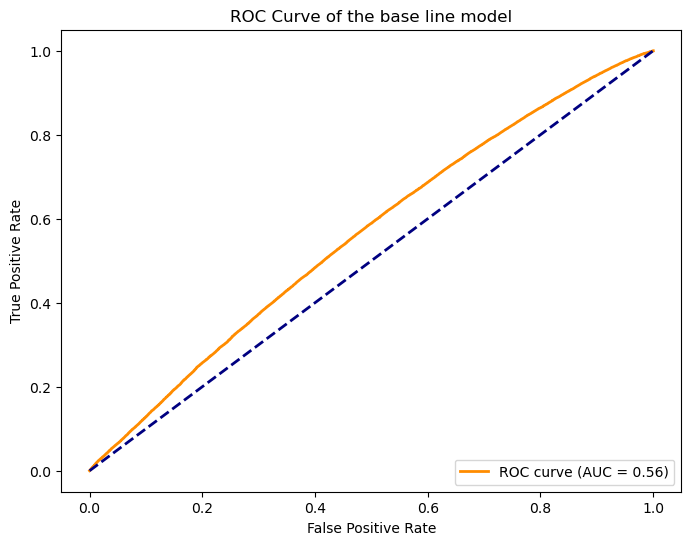

In [114]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the base line model')
plt.legend(loc='lower right')
plt.show()

So, without the fine tunning we get a accuracy of 50.44% and an AUC of 0,56, using the test data

## Fine tunning the model

Creating a class to train and fine tunning the model 

In [107]:
# Defining the training function on the 30% of the dataset for tuning the distilbert model
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
         #taking the inputs and label
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)
        #using the model
        outputs = model(ids, mask)
        #applying the loss function 
        loss = loss_function(outputs, targets)
        #sum the loss of the batch
        tr_loss += loss.item()
        # take the value and index of the max of the tensor
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [108]:
for epoch in range(EPOCHS):
    train(epoch)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.7143232822418213
Training Accuracy per 5000 steps: 25.0
Training Loss per 5000 steps: 0.4509439964724157
Training Accuracy per 5000 steps: 79.35912817436513
Training Loss per 5000 steps: 0.43012313462355034
Training Accuracy per 5000 steps: 80.38196180381962
Training Loss per 5000 steps: 0.41886457473235317
Training Accuracy per 5000 steps: 81.04959669355377
Training Loss per 5000 steps: 0.4095727964798662
Training Accuracy per 5000 steps: 81.48217589120544
Training Loss per 5000 steps: 0.4048621101829165
Training Accuracy per 5000 steps: 81.73373065077396
Training Loss per 5000 steps: 0.40004771428339736
Training Accuracy per 5000 steps: 82.00059998000067
Training Loss per 5000 steps: 0.3956835331723324
Training Accuracy per 5000 steps: 82.21407959772579
Training Loss per 5000 steps: 0.3926926827251231
Training Accuracy per 5000 steps: 82.38419039524013
Training Loss per 5000 steps: 0.3897502027058962
Training Accuracy per 5000 steps: 82.49983333703696


# Evaluate 
In this part the calculation of the metrics are made and we compare it with our baseline

In [109]:
acc,class1_fn,target_np_fn = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

C:\Users\ryosa\AppData\Local\Temp\ipykernel_14812\3104628365.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(outputs)


Validation Loss per 5000 steps: 0.03110179491341114
Validation Accuracy per 5000 steps: 100.0
Validation Loss per 5000 steps: 0.3419792628002522
Validation Accuracy per 5000 steps: 85.12297540491902
Validation Loss per 5000 steps: 0.338892038576385
Validation Accuracy per 5000 steps: 85.15648435156484
Validation Loss per 5000 steps: 0.34211515137527415
Validation Accuracy per 5000 steps: 84.99100059996
Validation Loss per 5000 steps: 0.3403636842364382
Validation Accuracy per 5000 steps: 85.03574821258937
Validation Loss per 5000 steps: 0.3401965048419637
Validation Accuracy per 5000 steps: 85.10859565617375
Validation Loss per 5000 steps: 0.34114771938966676
Validation Accuracy per 5000 steps: 85.05549815006167
Validation Loss per 5000 steps: 0.3406075476376481
Validation Accuracy per 5000 steps: 85.07614068169481
Validation Loss per 5000 steps: 0.33934109876680657
Validation Accuracy per 5000 steps: 85.1553711157221
Validation Loss per 5000 steps: 0.338536943341258
Validation Accurac

In [110]:
# Parameters to make the roc curve
fpr_fn, tpr_fn, thresholds_fn = metrics.roc_curve(target_np_fn, class1_fn)

#AUC calculation
roc_auc = metrics.auc(fpr_fn, tpr_fn)


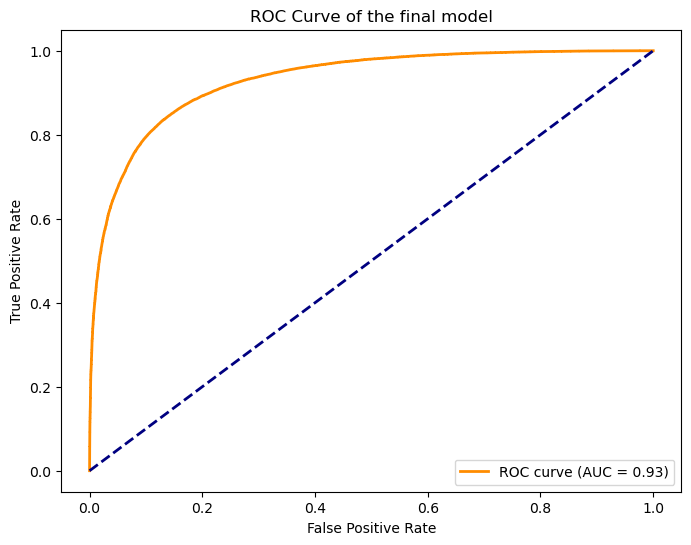

In [111]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_fn, tpr_fn, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the final model')
plt.legend(loc='lower right')
plt.show()

# Saving the model

In [ ]:
# Saving the files for re-use

output_model_file = './models/model.pt'
output_vocab_file = './models/vocab_distilbert_twitter.bin'

model_to_save = model
torch.save(model_to_save.state_dict(), output_model_file)
tkzr.save_vocabulary(output_vocab_file)


print('All files saved')